<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="right"></a>
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->

<h1 align=left><font size = 6, style="color:rgb(200,0,0)">Redes Neurais</font></h1>
<hr>

# **IMPORTANTE:** Antes de começar 

Execute a célula final desse Lab. Ela irá **inicializar** o seu ambiente com rotinas que são empregadas aqui.

## Neurônio simples
 
Um neurônio artificial nada mais é do que um artefato de software que faz uma combinação linear das entradas e aplica um função de ativação como a função $sign$, $tanh$ ou $relu$ para produzir uma saída.

$$ f(X) = sign( w_0 + w_1 x_1 + ... + w_n x_n ) $$

O treinamento do neurônio é feito ajustando-se os pesos $w_n$ de acordo com o erro de predição obtido para se estimar a saída $f(X) \cong y$.

$$ \min_{W} \sum || f(X)- y || $$


## Treinando a função **OR**

O código abaixo mostra o treinamento da função **OR** com um único neurônio com função de ativação $sign$ (função sinal).

Função $OR(X) \rightarrow y$:

```
  X     y
 0 0    0
 0 1    1
 1 0    1
 1 0    1
```

[[-1. -1. -1.  1.]]
[[-1. -1.  0.  1.]]
[[-1.  0.  0.  1.]]
[[-1.  1.  1.  1.]]


Text(0.5, 1.0, 'Training Error')

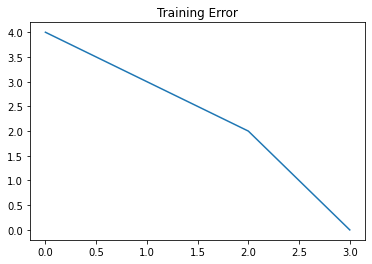

In [ ]:
X = np.matrix([ [0,0], [1,0], [0,1], [1,1] ])
y = np.matrix( [-1, 1, 1, 1] )

error = []
W1 = np.matrix([ [0.4,0.4] ])               # initial Weigths
W0 = -0.5
y_pred = np.sign( W1*X.T + W0 )
print(y_pred)
error.append(np.abs( (y_pred - y).sum() ))

W1 = np.matrix([ [0.4,0.5] ])
W0 = -0.5
y_pred = np.sign( W1*X.T + W0 )
print(y_pred)
error.append(np.abs( (y_pred - y).sum() ))

W1 = np.matrix([ [0.5,0.5] ])
W0 = -0.5
y_pred = np.sign( W1*X.T + W0 )
print(y_pred)
error.append(np.abs( (y_pred - y).sum() ))

W1 = np.matrix([ [0.5,0.5] ])
W0 = -0.4
y_pred = np.sign( W1*X.T + W0 )
print(y_pred)
error.append(np.abs( (y_pred - y).sum() ))

sns.lineplot(range(4),error)
plt.title('Training Error')

## Redes neurais 
 
Um único neurônio entretanto tem uma capacidade limitada de aprendizado. Por exemplo, ele não consegue aprender a função **XOR**.


Função $XOR(X) \rightarrow y$:

```
  X     y
 0 0    0
 0 1    1
 1 0    1
 1 0    0
```

Pois um único neurônio somente tem capacidade para fazer a separação de conjuntos linearmente separáveis.

Para resolver essa limitação podemos então trabalhar com múltiplos neurônios em camadas. As saídas dos neurônios de uma camada são então empregadas como entradas para a camada seguinte. As camadas entre a camada inicial de neurônios (de entrada) e a camada final (de saída) constitui as camadas ocultas da rede.

O treinamento da rede segue o mesmo princípio, embora mais complexo, ajustando os pesos $w_n$ de acordo com o erro de predição obtido para se estimar a saída $f(X) \cong y$.

$$ \min_{W} \sum || f(X)- y || $$

Chamamos esse aprendizado de *backpropagation* ou *retropropagação*.

Acesse agora http://playground.tensorflow.org/ para uma demonstração.

## **Case**: Detecção de Fraude em Operações de Cartão de Crédito

http://meusite.mackenzie.br/rogerio/ML/The-InfoQ-eMag-Introduction-to-Machine-Learning.pdf

Esse artigo trás uma ótima introdução ao Aprendizado de Máquina. O artigo demonstra a aplicação de dois modelos de classificação,**Árvores de Decisão e Regressão Logística**, para um conjunto de dado simples para detecção de fraude em operações de cartões de crédito. 

Aqui você vai empregar o mesmo conjunto de dados para um aprendizado de Deep Learning com **TensorFlow+Keras**. 

URL: https://meusite.mackenzie.br/rogerio/ML/qconlondon2016_sample_data.csv

**IMPORTANTE** 
O uso de deeplearning pode ser bastante complexo e exigiria um bom tempo para estarmos aptos a empregar suas funções em diferentes problemas. Entenda esse exemplo como uma *degustação* do deep learning apenas para que você possa fixar os conceitos dessa técnica.

## Explorando os dados


In [ ]:
# imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
import os
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential, layers
import tensorflow as tf

In [ ]:
fraud = pd.read_csv("https://meusite.mackenzie.br/rogerio/ML/qconlondon2016_sample_data.csv")
fraud.drop(columns=['charge_time'],inplace=True) # por simplicidade excluímos esse dado do treinamento
                     
print(fraud.head())
print(fraud.shape) 



   fraudulent  amount card_country  card_use_24h
0       False   20484           US             0
1       False    1211           US             0
2       False    8396           US             1
3       False    2359           US             0
4       False    1480           US             3
(89393, 4)


## Preparando os dados `X` e `y`

A preparação dos dados pode ser bastante complexa. Aqui ela envolve o **hot encode** dos atributos não numéricos, o rescaling dos dados e ainda a formatação dos dados para os padrões do **TensorFlow/Keras** (formato de matrizes e não dataframes).

**Preparando a entrada `X` (hot encode, Scaler).**

In [ ]:
X = fraud.drop(columns=['fraudulent'])
    
X_number = X.select_dtypes(include='number')
X_categorical = X.select_dtypes(exclude='number')
    
dummies = [pd.get_dummies(X[c],prefix=c, prefix_sep='_') for c in X_categorical.columns]
X = pd.concat(dummies, axis=1)
    
frames = [X_number,X]
X = pd.concat(frames, axis=1)
X.iloc[0]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_matrix = scaler.transform(X)
temp = X.index
X = pd.DataFrame(X_matrix,columns=X.columns)
X.index = temp
X.describe()


,amount,card_use_24h,card_country_AU,card_country_GB,card_country_US
count,8.939300e+04,8.939300e+04,8.939300e+04,8.939300e+04,8.939300e+04
mean,3.053817e-16,-1.729873e-14,-9.032136e-18,4.297227e-14,-9.967645e-14
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-2.372910e-01,-1.729671e-01,-1.567963e-01,-1.782893e-01,-4.152974e+00
25%,-1.981673e-01,-1.729671e-01,-1.567963e-01,-1.782893e-01,2.407913e-01
50%,-1.619712e-01,-1.280861e-01,-1.567963e-01,-1.782893e-01,2.407913e-01
75%,-7.765084e-02,-3.832406e-02,-1.567963e-01,-1.782893e-01,2.407913e-01
max,1.153412e+02,3.869400e+01,6.377700e+00,5.608862e+00,2.407913e-01


**Preparando a saída `y`**

Valores numéricos para a saída de rede.

In [ ]:
fraud.fraudulent = fraud.fraudulent.replace(True,1)
fraud.fraudulent = fraud.fraudulent.replace(False,0)

y = fraud.fraudulent

## Separando os dados de Treinamento e Teste

In [ ]:
seed = 1984
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed)


## Adequando os dados para o `Keras`

Os dados são reformatados em matrizes e a saída em uma matriz binária.

In [ ]:
Xm = X_train
Xm = np.matrix(Xm)

ym = y_train
ym = np.transpose(np.matrix(ym))

from keras.utils import to_categorical
y_binary = to_categorical(ym)


## Configuração e Treinamento da Rede DeepLearning

Nossa rede terá 5 neurônios de entrada, correspondendo a cada atributo de entrada, duas camadas ocultas de 8 neurônios, e uma camada de saída com 2 neurônios correspondendo às duas classes de saída.

```
model = Sequential([layers.Dense(Xm.shape[1], activation='sigmoid', input_shape=[Xm.shape[1],])]) 

model.add(layers.Dense(8, activation='sigmoid'))
model.add(layers.Dense(8, activation='sigmoid'))
model.add(layers.Dense(2, activation='sigmoid'))
```



In [ ]:
all_results = [] 

# Definição

model = Sequential([layers.Dense(Xm.shape[1], activation='sigmoid', input_shape=[Xm.shape[1],])]) 

model.add(layers.Dense(8, activation='sigmoid'))
model.add(layers.Dense(8, activation='sigmoid'))
model.add(layers.Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinamento
history = model.fit(Xm, y_binary, validation_split=0.2, epochs=100)


Epoch 1/100
1565/1565 [==============================] - 2s 1ms/step - loss: 0.6861 - accuracy: 0.5691 - val_loss: 0.6626 - val_accuracy: 0.6320
Epoch 2/100
1565/1565 [==============================] - 2s 1ms/step - loss: 0.6306 - accuracy: 0.6630 - val_loss: 0.6147 - val_accuracy: 0.6690
Epoch 3/100
1565/1565 [==============================] - 2s 1ms/step - loss: 0.6108 - accuracy: 0.6716 - val_loss: 0.6108 - val_accuracy: 0.6731
Epoch 4/100
1565/1565 [==============================] - 2s 1ms/step - loss: 0.6096 - accuracy: 0.6719 - val_loss: 0.6104 - val_accuracy: 0.6703
Epoch 5/100
1565/1565 [==============================] - 2s 1ms/step - loss: 0.6091 - accuracy: 0.6715 - val_loss: 0.6116 - val_accuracy: 0.6673
Epoch 6/100
1565/1565 [==============================] - 2s 1ms/step - loss: 0.6087 - accuracy: 0.6715 - val_loss: 0.6097 - val_accuracy: 0.6718
Epoch 7/100
1565/1565 [==============================] - 2s 1ms/step - loss: 0.6085 - accuracy: 0.6720 - val_loss: 0.6094 - val_ac

O Treinamento busca a cada etapa minimizar o erro (aumentar a acuracidade). Isso entretanto não ocorre de maneira regular. 

O Treinamento pode ser concluído quando se chega a uma determinado erro desejado ou após um certo número de iterações, uma vez que o modelo pode não convergir.

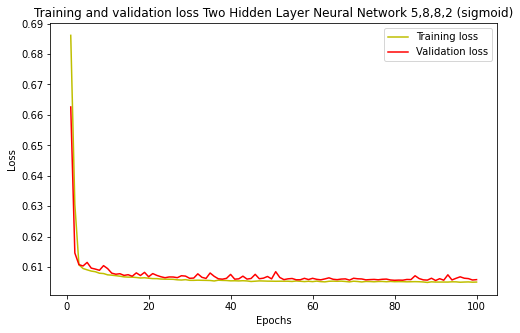

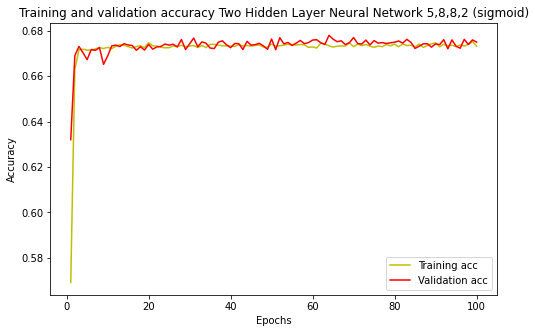

Two Hidden Layer Neural Network 5,8,8,2 (sigmoid)Accuracy Train: 67.33 %, Accuracy Test: 67.50 %


In [ ]:
loss, val_loss, acc, val_acc = plot_loss_acc(history,'Two Hidden Layer Neural Network 5,8,8,2 (sigmoid)')


Em cada neurônio de saída a rede retorna a probabilidade da classe. A seleção do neurônio de maior valor a classe mais provável (`np.argmax()`).

In [ ]:
# Predict

# Transforma as entradas em matriz para o Keras
Xm = X_test 
Xm = np.matrix(Xm)

# Predição
y_pred = np.argmax(model.predict(Xm), axis=-1)
    
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[10497  3055]
 [ 5838  7428]]
              precision    recall  f1-score   support

         0.0       0.64      0.77      0.70     13552
         1.0       0.71      0.56      0.63     13266

    accuracy                           0.67     26818
   macro avg       0.68      0.67      0.66     26818
weighted avg       0.68      0.67      0.66     26818



# **DESAFIO** $\rightarrow$ **Ganhe 0.5 adicional na N2**

Altere os códigos acima e **busque uma configuração da rede Deep Learning para obter uma acuracidade maior que 75%**.

Você pode:

1. Adicionar camadas
1. Alterar as funções de ativação
1. Alterar o número de neurônios de cada camada
 
Ou ainda quaisquer outros parâmetros que você pode encontrar em  configurações em https://keras.io/. Só não é permitido alterar o número de épocas do treinamento que deve permanecer em 100. Os conjuntos de Treinamento e Teste devem também ser mantidos, respeitando o seed 1984.

#### Entrega Individual
0.5 adicional na N1 para o aluno de cada turma que obtiver a maior acuracidade com valor mínimo de 75%. No caso de empate o 0.5 ponto adicional será dado para os alunos desde que as configurações sejam diferentes ou ao primeiro a fazer a entrega. Para configurações iguais somente a primeira entrega será considerada. 

Postar no canal **#geral** do Slack mensagem com **texto** contendo o valor de acuracidade obtido, turma e nome dos participantes, anexo ao  seu **ipynb** executável da solução.  

# **Bom Desafio!**

## **LAB SET UP**
Execute antes de iniciar o Lab.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
import os
warnings.filterwarnings("ignore")

from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential, layers
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def plot_loss_acc(history,more_title=''):
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss' + ' ' + more_title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.figure(figsize=(8,5))
    plt.plot(epochs, acc, 'y', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy' + ' ' + more_title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    print(more_title + 'Accuracy Train: {:.2f} %, Accuracy Test: {:.2f} %'.format(acc[len(acc)-1] *100, val_acc[len(val_acc)-1]*100))

    return loss, val_loss, acc, val_acc

print('T12 Set Up completed!')    

T12 Set Up completed!
